In [5]:
%matplotlib inline

In [6]:
#导入包
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
#对率函数
def h(x,w):
    if(len(x)!=len(w)):
        raise "w和x长度不同"
    e = np.exp(-x.dot(w))
    return 1/(1+e)
#选取部分数据
def select(X,y,num=100):
    selection_X = []
    selection_y = []
    selectIndex = np.random.randint(0,len(X),num)
    for i in selectIndex:
        selection_X.append(X[i])
        selection_y.append(y[i])
    return np.array(selection_X),np.array(selection_y)
#求梯度
def gradient(X,w,y):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    sum = 0
    for i in range(len(y)):
        sum += (h(X[i],w)-y[i])*X[i]
    return sum/len(y)
#NAG优化器
def NAG(X,w,y,trend):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    if(len(w)!=len(trend)):
        raise "w和trend的长度不同"
    a = 0.5
    b = 0.05

    trend = a*trend + gradient(X,w - a * b * trend,y)
    w = w - b * trend
    return w,trend
#RMS_prop优化器
def RMSprop(X,w,y,r):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    if(len(r)!=len(w)):
        raise "r和w的长度不同"
    e = 0.01
    p = 0.9
    g = gradient(X,w,y)
    r = p*r + (1-p)*g*g
    en = e/(np.sqrt(r)+1e-8)
    w -= en * g
    return w,r
#Adadelta优化器
def Adadelta(X,w,y,r,s):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    if(len(r)!=len(w)):
        raise "r和w的长度不同"
    if(len(s)!=len(w)):
        raise "s和w的长度不同"
    p = 0.9
    g = gradient(X,w,y)
    s = p*s + (1-p)*g*g
    g_ = np.sqrt(r+1e-8)/np.sqrt(s+1e-8)*g
    r = p*r + (1-p)*g_*g_
    w -= 3*g_
    return w,r,s
#Adam 优化器
def Adam(X,w,y,v,s,t):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    if(len(v)!=len(w)):
        raise "v和w的长度不同"
    if(len(s)!=len(w)):
        raise "s和w的长度不同"
    b1 = 0.9
    b2 = 0.999
    n = 0.01
    g = gradient(X,w,y)
    v = b1*v +(1-b1)*g
    s = b2*s +(1-b2)*g*g
    v_ = v/(1-b1**t)
    s_ = s/(1-b2**t)
    w -= n/np.sqrt(s_ + 1e-8)*v_
    return w,v,s
#损失函数
def loss_function(X,w,y):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    sum = 0
    for i in range(len(y)):
        if(y[i]==0):
            sum+=np.log(1-h(X[i],w))
        else:
            sum+=np.log(h(X[i],w))
    return -sum/len(y)
def accuracy(X,w,y):
    if(len(y)!=len(X)):
        raise "y和X长度不同"
    if(len(X[0])!=len(w)):
        raise "X的列数与w的长度不同"
    predict_list = np.array([int(2*h(X[i],w)) for i in range(len(X))])
    result = predict_list - y
    result[result!=0] = 1
    error_count = result.sum()
    return (len(y)-error_count)/len(y)

NAG accuracy: 0.831705669185
RMSprop accuracy: 0.84527977397
Adadelta accuracy: 0.781340212518
Adam accuracy: 0.848412259689


Text(0,0.5,'loss function')

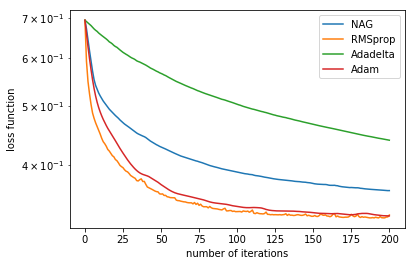

In [8]:
#读取训练数据
X_train,y_train = load_svmlight_file("a9a.txt")
X_train = X_train.toarray()
y_train[y_train == -1] = 0
#读取验证数据
X_validation,y_validation = load_svmlight_file("a9a.t")
X_validation = X_validation.toarray()
y_validation[y_validation == -1] = 0
#补全特征特征
ones = [[1]]*len(X_train)
X_train = np.concatenate((X_train,ones),axis = 1)
zeros = [[0]]*len(X_validation)
X_validation = np.concatenate((X_validation,zeros),axis = 1)
ones = [[1]]*len(X_validation)
X_validation = np.concatenate((X_validation,ones),axis = 1)
#参数初始化
w_nag = np.zeros(len(X_train[0]))
trend = np.zeros(len(w_nag))
w_rms = np.zeros(len(X_train[0]))
k = np.zeros(len(w_rms))
w_adadelta = np.zeros(len(X_train[0]))
r = np.zeros(len(w_adadelta))
s = np.zeros(len(w_adadelta))
w_adam = np.zeros(len(X_train[0]))
v = np.zeros(len(w_adam))
u = np.zeros(len(w_adam))

#保存各个优化方法的损失函数值
NAG_loss = [loss_function(X_validation,w_nag,y_validation)]
RMSprop_loss = [loss_function(X_validation,w_rms,y_validation)]
Adadelta_loss = [loss_function(X_validation,w_adadelta,y_validation)]
Adam_loss = [loss_function(X_validation,w_adam,y_validation)]
num_iteration = 200
for i in range(num_iteration):
    part_X,part_y = select(X_train,y_train)
    #进行NAG优化
    w_nag,trend = NAG(part_X,w_nag,part_y,trend)
    NAG_loss.append(loss_function(X_validation,w_nag,y_validation))
    #进行RMSprop优化
    w_rms,k = RMSprop(part_X,w_rms,part_y,k)
    RMSprop_loss.append(loss_function(X_validation,w_rms,y_validation))
    #进行adadelta优化
    w_adadelta,r,s = Adadelta(part_X,w_adadelta,part_y,r,s)
    Adadelta_loss.append(loss_function(X_validation,w_adadelta,y_validation))
    #进行adam优化
    w_adam,v,u = Adam(part_X,w_adam,part_y,v,u,i+1)
    Adam_loss.append(loss_function(X_validation,w_adam,y_validation))
#输出准确率
print("NAG accuracy:",accuracy(X_validation,w_nag,y_validation))
print("RMSprop accuracy:",accuracy(X_validation,w_rms,y_validation))
print("Adadelta accuracy:",accuracy(X_validation,w_adadelta,y_validation))
print("Adam accuracy:",accuracy(X_validation,w_adam,y_validation))
#画图
plt.plot(range(num_iteration+1),NAG_loss ,label="NAG")
plt.plot(range(num_iteration+1),RMSprop_loss,label = "RMSprop")
plt.plot(range(num_iteration+1),Adadelta_loss,label = "Adadelta")
plt.plot(range(num_iteration+1),Adam_loss,label = "Adam")
plt.yscale('log')
plt.legend(loc = "best")
ax = plt.gca()
ax.set_xlabel("number of iterations")
ax.set_ylabel("loss function")